Importing the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()


Univariate Statistics

In [ ]:
import pandas as pd
import numpy as np

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    # Clean up column names by stripping leading/trailing whitespace
    df.columns = df.columns.str.strip()
    # Drop the 'Unnamed: 0' column if it exists and is entirely NaN
    if 'Unnamed: 0' in df.columns and df['Unnamed: 0'].isnull().all():
        df = df.drop(columns=['Unnamed: 0'])
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please ensure the file is uploaded.")
    exit()

# --- Initial Inspection ---
print("--- DataFrame Head ---")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\n--- DataFrame Info ---")
df.info()

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

# =================================================================
# 1. Descriptive Statistics for Numerical Features
# =================================================================

# Define a custom function to get the mode (first value if multiple modes exist)
def get_mode(x):
    # Check if the series is empty or all NaNs, return NaN if so to avoid IndexError
    if x.isnull().all() or x.empty:
        return np.nan
    modes = x.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return np.nan # Should not happen if x is not empty and not all NaNs

# Calculate the required statistics
stats_df = df[numerical_cols].agg(
    ['mean', 'median', 'std', 'var', 'min', 'max', get_mode]
)
# Rename the index label 'get_mode' to 'mode'
stats_df = stats_df.rename(index={'get_mode': 'mode'})

# Transpose the DataFrame so that statistics become columns
stats_df = stats_df.T

# Calculate Range: Max - Min
stats_df['range'] = stats_df['max'] - stats_df['min']

# Rename columns to match user's request: 'std' to 'SD'
stats_df.rename(columns={'std': 'SD'}, inplace=True)

# Select and reorder columns
stats_df = stats_df[['mean', 'median', 'SD', 'var', 'mode', 'range', 'min', 'max']]

# Save to CSV
stats_df.to_csv("numerical_statistics.csv", index=True)

print("\n" + "="*80)
print("1. NUMERICAL FEATURE STATISTICS (Mean, Median, Mode, Range, Variance, SD, Min, Max)")
print("="*80)
print(stats_df.to_markdown(numalign="left", stralign="left"))


# =================================================================
# 2. Analysis for Categorical Features
# =================================================================

# Detailed summary for all categorical columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary.to_csv("categorical_summary.csv", index=True)

print("\n" + "="*80)
print("2. CATEGORICAL FEATURE SUMMARY (Count, Unique, Top, Freq)")
print("="*80)
print(categorical_summary.to_markdown(numalign="left", stralign="left"))

print("\n" + "="*80)
print("2.1 CATEGORICAL FEATURE VALUE COUNTS AND PERCENTAGES (Top 5)")
print("="*80)

# Columns of interest for frequency analysis
key_categorical_cols = ['Crude type', 'Sulfur Flavour', 'Region', 'Country']

for col in key_categorical_cols:
    value_counts = df[col].value_counts()
    percentage = df[col].value_counts(normalize=True).mul(100).round(2)
    temp_df = pd.DataFrame({
        'Count': value_counts,
        'Frequency (%)': percentage
    })

    print(f"\nFeature: {col}")
    # Print the top 5 values
    print(temp_df.head(5).to_markdown(numalign="left", stralign="left"))

Univariate Plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")



# VISUALIZATION FUNCTION

def plot_distributions(df, plot_type='histogram'):
    """
    Plots histograms or boxplots for all numerical columns in the dataframe.
    """
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_vars = len(numerical_cols)

    # Calculate grid size (3 columns wide)
    n_cols = 3
    n_rows = math.ceil(num_vars / n_cols)

    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    # Loop through each variable and plot
    for i, col in enumerate(numerical_cols):
        if plot_type == 'histogram':
            sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
            axes[i].set_title(f'Histogram: {col}', fontsize=10)
            axes[i].set_ylabel('Frequency')
        elif plot_type == 'boxplot':
            sns.boxplot(x=df[col], ax=axes[i], color='lightgreen')
            axes[i].set_title(f'Boxplot: {col}', fontsize=10)

        axes[i].set_xlabel(col, fontsize=9)

    # Remove empty subplots
    for i in range(num_vars, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


# GENERATE PLOTS

# 1. Generate Histograms for ALL variables
print("\n" + "="*50)
print("GENERATING HISTOGRAMS (Distributions)")
print("="*50)
plot_distributions(df, plot_type='histogram')

# 2. Generate Box Plots for ALL variables
print("\n" + "="*50)
print("GENERATING BOX PLOTS (Outlier Detection)")
print("="*50)
plot_distributions(df, plot_type='boxplot')

Bivariate Statistics

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr

# ------------------------------------------------------------------
# STEP 1: LOAD DATA
# ------------------------------------------------------------------

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# Select numerical columns only
numerical_cols = df.select_dtypes(include=['number']).columns
df_num = df[numerical_cols]

# ------------------------------------------------------------------
# STEP 2: DEFINE DISTANCE CORRELATION FUNCTION
# ------------------------------------------------------------------
def distcorr(X, Y):
    """ Computes the distance correlation between two vectors. """
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X): X = X[:, None]
    if np.prod(Y.shape) == len(Y): Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]: raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    dcov2_xy = (A * B).sum() / float(n * n)
    dcov2_xx = (A * A).sum() / float(n * n)
    dcov2_yy = (B * B).sum() / float(n * n)
    return np.sqrt(dcov2_xy) / np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))

# ------------------------------------------------------------------
# STEP 3: CALCULATE MATRICES
# ------------------------------------------------------------------

# 1. Pearson Correlation (Linear relationships)
pearson_corr = df_num.corr(method='pearson')

# 2. Spearman Correlation (Rank/Non-linear relationships)
spearman_corr = df_num.corr(method='spearman')

# 3. Distance Correlation (Non-linear & Dependence)
dist_corr_matrix = pd.DataFrame(index=numerical_cols, columns=numerical_cols)
print("Calculating Distance Correlation Matrix... (this may take a moment)")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        dist_corr_matrix.loc[col1, col2] = distcorr(df_num[col1].values, df_num[col2].values)
dist_corr_matrix = dist_corr_matrix.astype(float)

# 4. Mutual Information (Dependency & Information Gain)
mi_matrix = pd.DataFrame(index=numerical_cols, columns=numerical_cols)
print("Calculating Mutual Information Matrix...")
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 == col2:
            mi_matrix.loc[col1, col2] = np.nan
        else:
            # Reshape is required for sklearn
            mi = mutual_info_regression(df_num[col1].values.reshape(-1, 1), df_num[col2].values, random_state=42)[0]
            mi_matrix.loc[col1, col2] = mi
mi_matrix = mi_matrix.astype(float)

# ------------------------------------------------------------------
# STEP 4: SAVE RESULTS
# ------------------------------------------------------------------
pearson_corr.to_csv('pearson_correlation.csv')
spearman_corr.to_csv('spearman_correlation.csv')
dist_corr_matrix.to_csv('distance_correlation.csv')
mi_matrix.to_csv('mutual_information.csv')

print("All correlation matrices saved to CSV.")

Multivariate Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------------------------------------------------------------
# 1. SETUP & DATA LOADING
# ----------------------------------------------------------------------------------
# Create a directory to store the report images
output_dir = 'Report_Images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# Separate Numerical and Categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# ----------------------------------------------------------------------------------
# 2. THE MASTER HEATMAP (Correlation Matrix)
# ----------------------------------------------------------------------------------
print("Generating Master Heatmap...")
plt.figure(figsize=(24, 20))  # Large size for readability
corr_matrix = df[numerical_cols].corr()

# Create a mask to hide the upper triangle (redundant info)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.5, cbar_kws={"shrink": .5}, annot_kws={"size": 8})

plt.title('Comprehensive Correlation Matrix (All Variables)', fontsize=20)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig(f'{output_dir}/Master_Correlation_Heatmap.png', dpi=300)
plt.close()


# ----------------------------------------------------------------------------------
# 3. AUTOMATED SCATTER PLOTS (Strong Relationships Only)
# ----------------------------------------------------------------------------------
# Instead of plotting everything, we find pairs with correlation > 0.7 or < -0.7
print("Generating Scatter Plots for Strong Correlations...")

threshold = 0.70
# Get pairs of features with high correlation
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j, corr_matrix.iloc[i, j]))

# Plot top 20 strongest relationships to avoid too many files (or remove [:20] to do all)
for col_x, col_y, corr_val in high_corr_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col_x, y=col_y, hue='Crude type', palette='viridis', s=80)
    plt.title(f'{col_x} vs {col_y}\nCorrelation: {corr_val:.2f}', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Save with a clean filename
    safe_name_x = col_x.replace('/', '_').replace(' ', '_')
    safe_name_y = col_y.replace('/', '_').replace(' ', '_')
    plt.savefig(f'{output_dir}/Scatter_{safe_name_x}_vs_{safe_name_y}.png')
    plt.close()


# ----------------------------------------------------------------------------------
# 4. FULL PAIR PLOT (Caution: Large Image)
# ----------------------------------------------------------------------------------
# Because 27 variables is too big for one pairplot, we split it into logical groups
print("Generating Grouped Pair Plots...")

# Group 1: Physical Properties
phys_vars = ['API Gravity', 'Density @ 15°C (g/cc)', 'Viscosity @ 20°C (cSt)',
             'Pour Point (°C)', 'Reid Vapor Pressure (kPa)']
# Filter only those that exist in df
phys_vars = [c for c in phys_vars if c in df.columns]

if phys_vars:
    sns.pairplot(df[phys_vars + ['Crude type']], hue='Crude type', palette='bright')
    plt.suptitle("Pair Plot: Physical Properties", y=1.02, fontsize=16)
    plt.savefig(f'{output_dir}/Pairplot_Physical.png')
    plt.close()

# Group 2: Contaminants
contam_vars = ['Total Sulfur (% wt)', 'Total Nitrogen (ppm)', 'Nickel (ppm)',
               'Vanadium (ppm)', 'Salt (ptb)', 'Total Acid Number (mgKOH/g)']
contam_vars = [c for c in contam_vars if c in df.columns]

if contam_vars:
    sns.pairplot(df[contam_vars + ['Crude type']], hue='Crude type', palette='bright')
    plt.suptitle("Pair Plot: Contaminants", y=1.02, fontsize=16)
    plt.savefig(f'{output_dir}/Pairplot_Contaminants.png')
    plt.close()

# Group 3: Light Ends (Composition)
comp_vars = ['methane + ethane', 'propane', 'isobutane', 'n-butane',
             'isopentane', 'n-pentane']
comp_vars = [c for c in comp_vars if c in df.columns]

if comp_vars:
    sns.pairplot(df[comp_vars + ['Crude type']], hue='Crude type', palette='bright')
    plt.suptitle("Pair Plot: Light Ends Composition", y=1.02, fontsize=16)
    plt.savefig(f'{output_dir}/Pairplot_LightEnds.png')
    plt.close()

print(f"All images have been saved to the folder: {output_dir}")

Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Configuration for Preprocessing
# Target for this example: API Gravity (Regression)
target_col = 'API Gravity'

# Features to Log Transform (to fix skewness)
LOG_FEATURES = ['Viscosity @ 20°C (cSt)', 'Viscosity @ 40°C (cSt)',
                'Nickel (ppm)', 'Vanadium (ppm)']

# Categorical Features to Encode
CAT_FEATURES = ['Region', 'Sulfur Flavour', 'Country']

# Columns to Drop (IDs and Leakage)
DROP_COLS = ['Reference', 'Crude', 'Density @ 15°C (g/cc)']

# 3. separate Features (X) and Target (y)
X = df.drop(columns=DROP_COLS + [target_col])
y = df[target_col]

# 4. Apply Log Transformation
for col in LOG_FEATURES:
    if col in X.columns:
        # np.log1p calculates log(1 + x) to handle zeros safely
        X[col] = X[col].apply(np.log1p)

# 5. Define Transformation Pipelines
# Numerical Pipeline: Impute -> Scale
num_cols = X.select_dtypes(include=['number']).columns.tolist()
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Impute -> One-Hot Encode
cat_cols = [c for c in CAT_FEATURES if c in X.columns]
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine Pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ],
    verbose_feature_names_out=False # Keeps column names clean
)

# 6. Apply Transformations & Reconstruct DataFrame
X_processed_array = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Create the final "Updated Dataset" DataFrame
updated_df = pd.DataFrame(X_processed_array, columns=feature_names)

# Optional: Add target back to see the full picture
updated_df[target_col] = y.values

# 7. Display Result
print("--- Updated Dataset (Processed & Scaled) ---")
print(updated_df.head())
print(f"\nFinal Shape: {updated_df.shape}")


# 8. Save to CSV
output_filename = 'processed_crude_oil_data.csv'
updated_df.to_csv(output_filename, index=False)
print(f"Successfully saved '{output_filename}' in the runtime environment.")

# 9. Trigger Download (Specific to Google Colab)
try:
    from google.colab import files
    files.download(output_filename)
except ImportError:
    print("This command only works in Google Colab. The file is saved locally.")

Classification models (code)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Load Data
file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Configuration
LOG_FEATURES = ['Viscosity @ 20°C (cSt)', 'Viscosity @ 40°C (cSt)', 'Nickel (ppm)', 'Vanadium (ppm)']

# 3. Helper Function to Train and Evaluate
def train_evaluate_model(target, features, model_type='svm_linear'):
    print(f"\n--- Training {model_type.upper()} for Target: {target} ---")

    # Prepare Data
    X = df[features].copy()
    y = df[target].copy()

    # Log Transform
    for col in LOG_FEATURES:
        if col in X.columns:
            X[col] = X[col].apply(np.log1p)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Pipeline
    num_cols = X.select_dtypes(include=['number']).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(drop='first'))]), cat_cols)
    ])

    # Select Model
    if model_type == 'svm_linear':
        clf = SVC(kernel='linear', random_state=42)
    elif model_type == 'logreg':
        clf = LogisticRegression(random_state=42)
    elif model_type == 'rf':
        clf = RandomForestClassifier(random_state=42)

    # Pipeline
    model = Pipeline([('preprocessor', preprocessor), ('classifier', clf)])

    # Train & Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Report
    print(classification_report(y_test, y_pred))
    return model

# --- Run Recommended Models ---

# 1. Crude Type -> Linear SVM
features_crude = ['Density @ 15°C (g/cc)', 'API Gravity', 'Viscosity @ 20°C (cSt)',
                  'Viscosity @ 40°C (cSt)', 'C7 naphthenes', 'C7 paraffins',
                  'Total Nitrogen (ppm)', 'Nickel (ppm)']
model_crude = train_evaluate_model('Crude type', features_crude, 'svm_linear')

# 2. Sulfur Flavour -> Logistic Regression
features_sulfur = ['Vanadium (ppm)', 'Region', 'Crude type']
model_sulfur = train_evaluate_model('Sulfur Flavour', features_sulfur, 'logreg')

Classifiaction models (Visuals)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Load Data
file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Plotting Function
def plot_model_performance(model, X_test, y_test, le, title):
    """
    Generates Confusion Matrix and ROC Curve side-by-side.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Setup Plot Grid
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- A. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
    axes[0].set_title(f'Confusion Matrix: {title}', fontsize=14)
    axes[0].set_ylabel('Actual Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)

    # --- B. ROC Curve ---
    n_classes = len(le.classes_)
    if n_classes == 2:
        # Binary Classification
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        # Multi-class Classification (One-vs-Rest)
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        colors = ['blue', 'green', 'red']
        for i, color in zip(range(n_classes), colors):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, color=color, lw=2,
                         label=f'Class: {le.classes_[i]} (AUC = {roc_auc:.2f})')

    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate', fontsize=12)
    axes[1].set_ylabel('True Positive Rate', fontsize=12)
    axes[1].set_title(f'ROC Curve: {title}', fontsize=14)
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# 3. Train & Visualize Function
def run_visual_experiment(target, features, model_type='svm'):
    print(f"Running Experiment for: {target}")

    # Prep Data
    X = df[features].copy()
    y = df[target].copy()

    # Log Transform Skewed Features
    for col in ['Viscosity @ 20°C (cSt)', 'Vanadium (ppm)']:
        if col in X.columns: X[col] = X[col].apply(np.log1p)

    # Encode Target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Pipeline
    num_cols = X.select_dtypes(include=['number']).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(drop='first'))]), cat_cols)
    ])

    # Select Model
    if model_type == 'svm':
        clf = SVC(kernel='linear', probability=True, random_state=42)
        name = "Linear SVM"
    else:
        clf = LogisticRegression(random_state=42)
        name = "Logistic Regression"

    model = Pipeline([('preprocessor', preprocessor), ('classifier', clf)])
    model.fit(X_train, y_train)

    # Visualize
    plot_model_performance(model, X_test, y_test, le, name)

# --- EXECUTE ---
# 1. Crude Type (SVM)
run_visual_experiment('Crude type',
                      ['Density @ 15°C (g/cc)', 'API Gravity', 'Viscosity @ 20°C (cSt)', 'Total Nitrogen (ppm)'],
                      model_type='svm')

# 2. Sulfur Flavour (Logistic Regression)
run_visual_experiment('Sulfur Flavour',
                      ['Vanadium (ppm)', 'Region', 'Crude type'],
                      model_type='logreg')

Crude type decision boundary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Select Features & Target
# Using the two strongest physical differentiators
feature_x = 'API Gravity'
feature_y = 'Viscosity @ 20°C (cSt)'
target = 'Crude type'

X = df[[feature_x, feature_y]].copy()
y = df[target].copy()

# 3. Preprocessing
# Log Transform Viscosity (essential to see the separation clearly)
X[feature_y] = np.log1p(X[feature_y])
y_encoded = LabelEncoder().fit_transform(y)

# 4. Train Model
# We use a Pipeline to Scale data before SVM (SVM relies on distance, so scaling is mandatory)
model = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0))
model.fit(X, y_encoded)

# 5. Generate Grid for Decision Boundary
x_min, x_max = X[feature_x].min() - 5, X[feature_x].max() + 5
y_min, y_max = X[feature_y].min() - 1, X[feature_y].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict on Grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 6. Plot
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm') # The background color regions
scatter = plt.scatter(X[feature_x], X[feature_y], c=y_encoded, cmap='coolwarm', edgecolors='k', s=80)
plt.xlabel('API Gravity (Higher = Lighter)')
plt.ylabel('Log(Viscosity) (Higher = Heavier)')
plt.title('SVM Decision Boundary: Crude Type Classification')
plt.show()

Sulfur Flavour decision boundary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Select Features & Target
# X-axis: Vanadium (The "Sour" Driver)
# Y-axis: API Gravity (The "Quality" Context)
feature_x = 'Vanadium (ppm)'
feature_y = 'API Gravity'
target = 'Sulfur Flavour'

X = df[[feature_x, feature_y]].copy()
y = df[target].copy()

# 3. Preprocessing
# Log transform Vanadium for better visualization
X[feature_x] = np.log1p(X[feature_x])
y_encoded = LabelEncoder().fit_transform(y)

# 4. Train Model (Logistic Regression)
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X, y_encoded)

# 5. Generate Grid
x_min, x_max = X[feature_x].min() - 0.5, X[feature_x].max() + 0.5
y_min, y_max = X[feature_y].min() - 5, X[feature_y].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 6. Plot
plt.figure(figsize=(10, 8))
# Red = Sour, Green = Sweet
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
scatter = plt.scatter(X[feature_x], X[feature_y], c=y_encoded, cmap='RdYlGn', edgecolors='k', s=80)
plt.xlabel('Log(Vanadium ppm)')
plt.ylabel('API Gravity')
plt.title('Logistic Regression Decision Boundary: Sulfur Flavour')
plt.show()

Regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Configuration
LOG_FEATURES = ['Viscosity @ 20°C (cSt)', 'Viscosity @ 40°C (cSt)', 'Nickel (ppm)', 'Vanadium (ppm)', 'Mercaptan Sulfur (ppm)']

# 3. Helper Function
def run_regression(target, features):
    print(f"\n--- Regression for Target: {target} ---")
    X = df[features].copy()
    y = df[target].copy()

    # Log Transform
    for col in LOG_FEATURES:
        if col in X.columns: X[col] = X[col].apply(np.log1p)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pipeline
    num_cols = X.select_dtypes(include=['number']).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))]), cat_cols)
    ])

    # Models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(random_state=42),
        'LASSO': Lasso(random_state=42),
        'SVR (Linear)': SVR(kernel='linear'),
        'SVR (RBF)': SVR(kernel='rbf')
    }

    # Train & Evaluate
    results = []
    for name, model in models.items():
        pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        results.append({'Model': name, 'R2': r2, 'RMSE': rmse, 'MAE': mae})

    return pd.DataFrame(results).sort_values(by='R2', ascending=False)

# --- EXECUTE ---
# 1. API Gravity
feats_api = ['C7 paraffins', 'C6 paraffins', 'n-pentane', 'n-butane', 'Total Nitrogen (ppm)', 'Total Sulfur (% wt)', 'Pour Point (°C)']
print(run_regression('API Gravity', feats_api))

# 2. Total Sulfur
feats_sulfur = ['Vanadium (ppm)', 'Region', 'Total Acid Number (mgKOH/g)', 'Mercaptan Sulfur (ppm)']
print(run_regression('Total Sulfur (% wt)', feats_sulfur))

graphs for regresssion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Configuration
LOG_FEATURES = ['Viscosity @ 20°C (cSt)', 'Viscosity @ 40°C (cSt)',
                'Nickel (ppm)', 'Vanadium (ppm)', 'Mercaptan Sulfur (ppm)']

# 3. Plotting Function
def plot_regression_performance(model, X_test, y_test, title):
    """
    Generates an 'Actual vs Predicted' scatter plot.
    """
    y_pred = model.predict(X_test)

    # Calculate Metrics for the plot title
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    plt.figure(figsize=(8, 7))

    # Scatter plot of points
    sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6, s=80, edgecolor='k')

    # Perfect prediction line (The "Ideal" 45-degree line)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

    # Labels & Title
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title(f'{title}\nR²: {r2:.3f} | RMSE: {rmse:.3f}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# 4. Training Pipeline Function
def train_and_visualize(target, features, model_type='svr_linear'):
    print(f"\n--- Visualizing Regression for Target: {target} ---")

    # Prepare X and y
    X = df[features].copy()
    y = df[target].copy()

    # Log Transform Skewed Features
    for col in LOG_FEATURES:
        if col in X.columns:
            X[col] = X[col].apply(np.log1p)

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing
    num_cols = X.select_dtypes(include=['number']).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))]), cat_cols)
    ])

    # Select Model
    if model_type == 'svr_linear':
        regressor = SVR(kernel='linear')
        name = "Linear SVR"
    elif model_type == 'svr_rbf':
        regressor = SVR(kernel='rbf')
        name = "SVR (RBF Kernel)"
    else:
        regressor = LinearRegression()
        name = "Linear Regression"

    # Build & Train Pipeline
    model = Pipeline([('preprocessor', preprocessor), ('model', regressor)])
    model.fit(X_train, y_train)

    # Plot
    plot_regression_performance(model, X_test, y_test, f"{name} Performance: {target}")

# ==============================================================================
# 5. EXECUTE VISUALIZATIONS
# ==============================================================================

# Task 1: API Gravity (Best Model: Linear SVR)
features_api = ['C7 paraffins', 'C6 paraffins', 'n-pentane', 'n-butane',
                'Total Nitrogen (ppm)', 'Total Sulfur (% wt)', 'Pour Point (°C)']

train_and_visualize('API Gravity', features_api, model_type='svr_linear')


# Task 2: Total Sulfur (Best Model: SVR RBF - though performance is lower due to outliers)
features_sulfur = ['Vanadium (ppm)', 'Region', 'Total Acid Number (mgKOH/g)', 'Mercaptan Sulfur (ppm)']

train_and_visualize('Total Sulfur (% wt)', features_sulfur, model_type='svr_rbf')

Clustering (K-means)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Preprocessing
X = df.select_dtypes(include=['number'])
# Log Transform Skewed Features
for col in ['Viscosity @ 20°C (cSt)', 'Nickel (ppm)', 'Vanadium (ppm)']:
    if col in X.columns: X[col] = X[col].apply(np.log1p)

# Pipeline: Impute -> Scale
preprocessor = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
X_scaled = preprocessor.fit_transform(X)

# 3. K-Means Clustering
# We choose k=3 based on the Elbow Method and domain knowledge (Light/Medium/Heavy)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# 4. Visualization (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=100, style=df['Crude type'])
plt.title('K-Means Clustering of Crude Oil Samples')
plt.xlabel('PCA Component 1 (Quality Axis)')
plt.ylabel('PCA Component 2 (Composition Axis)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 5. Analysis
print(df.groupby('Cluster')[['API Gravity', 'Total Sulfur (% wt)', 'Viscosity @ 20°C (cSt)']].mean())

dendrogram

Data loaded successfully.


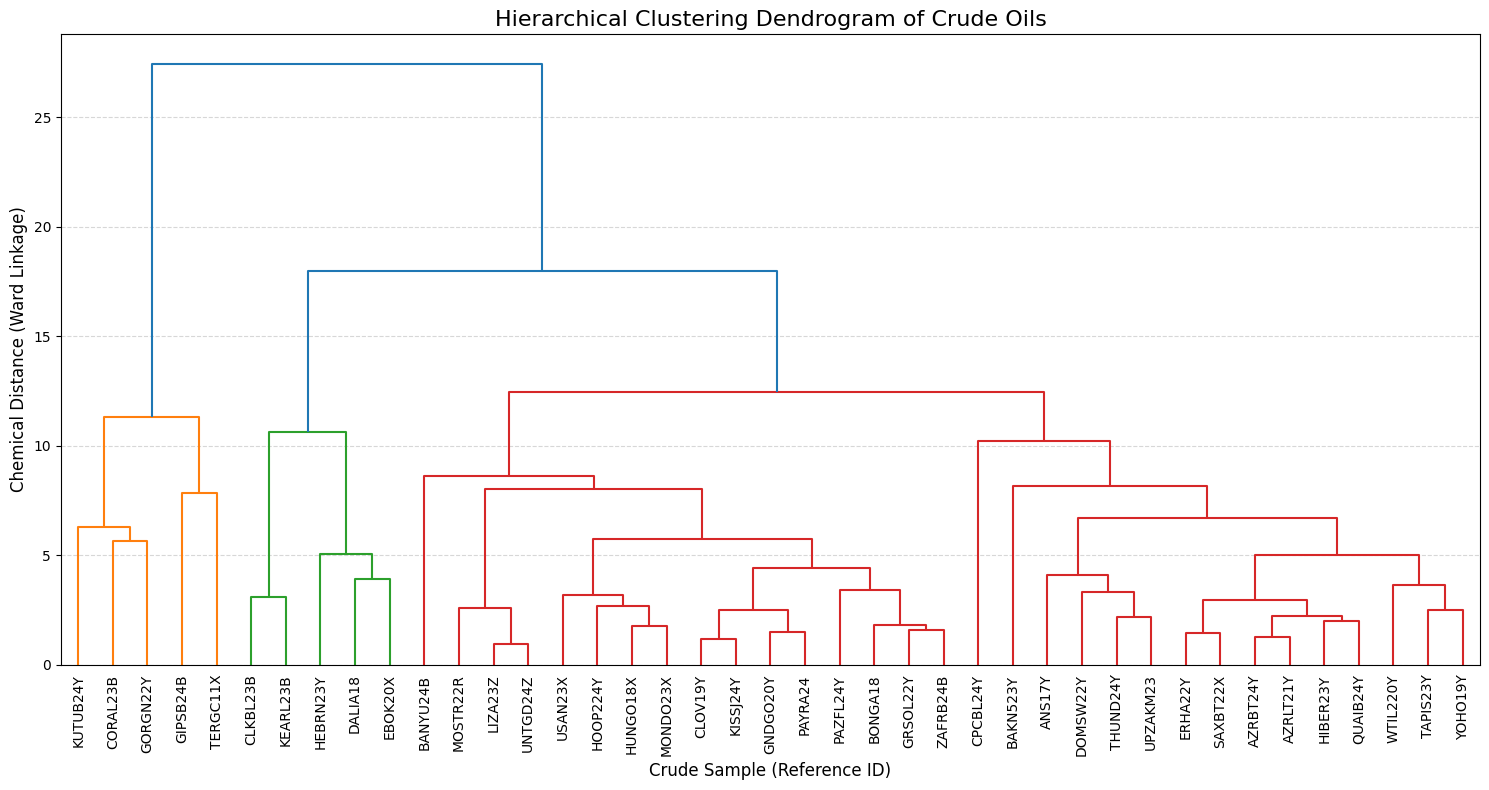

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

file_path = 'Crudeoil.xlsx'

try:
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip() # Clean column names
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")

# 2. Preprocessing
X = df.select_dtypes(include=['number'])
# Log Transform Skewed Features
for col in ['Viscosity @ 20°C (cSt)', 'Nickel (ppm)', 'Vanadium (ppm)']:
    if col in X.columns: X[col] = X[col].apply(np.log1p)

# Pipeline: Impute -> Scale
preprocessor = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
X_scaled = preprocessor.fit_transform(X)

# 3. Compute Linkage Matrix (Ward's Method)
# Ward's method minimizes variance within clusters
Z = linkage(X_scaled, method='ward')

# 4. Plot Dendrogram
plt.figure(figsize=(15, 8))
dendrogram(
    Z,
    labels=df['Reference'].values, # Label each leaf with the crude's ID
    leaf_rotation=90.,
    leaf_font_size=10.,
    color_threshold=15 # Color clusters that merge below this distance
)
plt.title('Hierarchical Clustering Dendrogram of Crude Oils', fontsize=16)
plt.xlabel('Crude Sample (Reference ID)', fontsize=12)
plt.ylabel('Chemical Distance (Ward Linkage)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()